# HOMEWORK 2


## CODE

In [50]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import math
from scipy.special import expit as sig
X_train = np.array(pd.read_csv("./hw2-data/X_train.csv", header=None))
X_test = np.array(pd.read_csv("./hw2-data/X_test.csv", header=None))
y_train = np.array(pd.read_csv("./hw2-data/y_train.csv", header=None))
y_test = np.array(pd.read_csv("./hw2-data/y_test.csv", header=None))
# X_train.head()

# HELPER FUNCTIONS
def BLL(X, T):
    return np.sum(X*np.log(T) + (1-X)*np.log(1-T), axis=1)
def PLL(X, T):    
    return np.sum(np.log(T) - (T+1)*np.log(X), axis=1)

# inpired from https://timvieira.github.io/blog/post/2014/02/11/exp-normalize-trick/
def sigmoid(x):
    return sig(x)

# BAYES_NAIVE_CLASSIFIER
class BNC():
    def fit(self, X, y):
        self.BNC_pi_0 = np.extract(y==0, y).size/y.size
        self.BNC_pi_1 = np.extract(y==1, y).size/y.size
        BX, PX = np.split(X, [54], axis =1)
        self.BNC_BT_0 = np.sum(BX[(y == 0).flatten(), :], axis=0)/np.extract(y==0, y).size
        self.BNC_BT_1 = np.sum(BX[(y == 1).flatten(), :], axis=0)/np.extract(y==1, y).size
        self.BNC_PT_0 = np.extract(y==0, y).size/ np.sum(np.log(PX[(y == 0).flatten(), :]), axis=0)
        self.BNC_PT_1 = np.extract(y==1, y).size/ np.sum(np.log(PX[(y == 1).flatten(), :]), axis=0)

    def forward_pass(self, X):
        BX, PX = np.split(X, [54], axis =1)
        y_pred_0 = np.log(self.BNC_pi_0) + BLL(BX, self.BNC_BT_0) + PLL(PX, self.BNC_PT_0)

        y_pred_1 = np.log(self.BNC_pi_1) + BLL(BX, self.BNC_BT_1) + PLL(PX, self.BNC_PT_1)
        return (y_pred_1>y_pred_0).astype(int).reshape((-1,1))
    
    def get_BT(self):
        return self.BNC_BT_0, self.BNC_BT_1

# K-Nearest Neighbour Classifier
class KNNC():
    def fit(self, X, y): #almost like init
        self.X = X
        self.y = y
        
    def ranked_NNs(self, X_t):
        return np.argsort(np.array([[np.sum(np.abs(j-i)) for j in self.X] for i in X_t]), axis=1)
        
    def forward_pass(self, k, ranked_nns):
        return np.around(np.mean(self.y[ranked_nns[:, :k]], axis=1)).astype(dtype=np.int)
        
# Logistic Regression

class LRC():
    def fit_train(self, X_l, y_l, n_iterations = 10000, LR_fun = "GA"):
        self.X = np.hstack((X_l, np.ones((X_l.shape[0], 1))))
        self.y = np.where(y_l == 1, 1, -1)
        self.w = np.zeros((self.X.shape[1], 1))
        self.iters = []
        self.Ls = []
        l_rate = 0
        for i in range(1,n_iterations+1):
            if LR_fun == "GA":
                l_rate = 1.0/(10**5*np.sqrt(i+1))
                L = np.sum(np.log(sigmoid(self.y*np.dot(self.X, self.w))+1e-10))
                self.w = self.w + l_rate*(np.sum((1-sigmoid(self.y*np.dot(self.X, self.w))
                                                 )*self.y*self.X, axis=0).reshape(self.w.shape))
                self.iters.append(i)
                self.Ls.append(L)
            elif LR_fun == "N":
                l_rate = 1.0/np.sqrt(i+1)
                L = np.sum(np.log(sigmoid(self.y*np.dot(self.X, self.w))+1e-10)) 
                grad = np.sum((1-sigmoid(self.y*np.dot(self.X, self.w)))*self.y*self.X, axis=0).reshape(self.w.shape)
                term = sigmoid(np.dot(self.X,self.w))
                second = np.zeros((self.X.shape[0],self.X.shape[1],self.X.shape[1]))
                for j in range(self.X.shape[0]):
                    arr=self.X[j].reshape([-1,1])
                    t3=np.dot(arr, arr.T)
                    second[j] = term[j]*(1-term[j])*t3
                second = -np.sum(second, axis=0)
                self.w += -np.dot(np.linalg.inv(second),grad)
                self.iters.append(i)
                self.Ls.append(L)
            else:
                print("Invalid learning rate function")
        return np.array(self.iters), np.array(self.Ls)
    
    def forward_pass(self, Xt):
        return (sigmoid(np.dot(np.hstack((Xt, np.ones((Xt.shape[0], 1)))), self.w))>0.5).astype(dtype=np.int)

## PROBLEMS
### Problem 2 - a

In [51]:
bnc = BNC()
bnc.fit(X_train, y_train)
results = bnc.forward_pass(X_test)
print("ACCURACY: ", np.extract(y_test==results, results).size/y_test.size*100)

OO = np.extract(np.logical_and(y_test == 0, results == 0), y_test).size
OI = np.extract(np.logical_and(y_test == 0, results == 1), y_test).size
IO = np.extract(np.logical_and(y_test == 1, results == 0), y_test).size
II = np.extract(np.logical_and(y_test == 1, results == 1), y_test).size

pd.DataFrame(np.array([[OO, OI],
          [IO, II]]))

ACCURACY:  92.47311827956989


,0,1
0,54,2
1,5,32


### Problem 2 - b

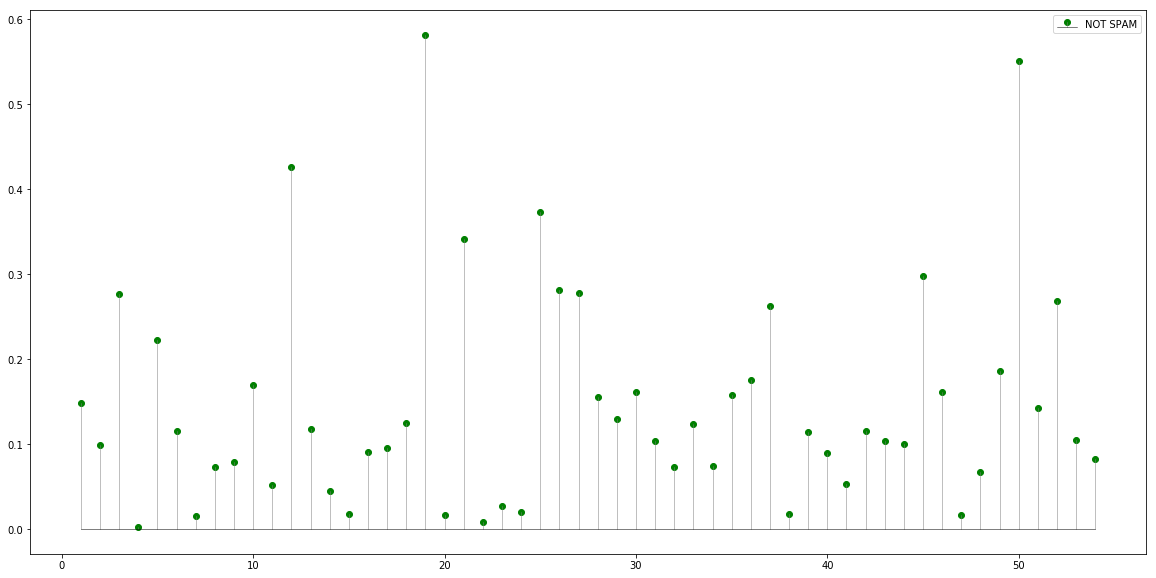

In [52]:
import matplotlib.pyplot as plt

indexes = np.arange(start=1, stop=55)
bt_0, bt_1 = bnc.get_BT()
plt.figure(figsize=(20, 10))
markerline, stemlines, baseline = plt.stem(indexes, bt_0, label="NOT SPAM")
plt.setp(baseline, color='black', linewidth=.5)
plt.setp(markerline, color='g')
plt.setp(stemlines, color='grey', linestyle='-', linewidth=.5)
plt.legend()
plt.show()

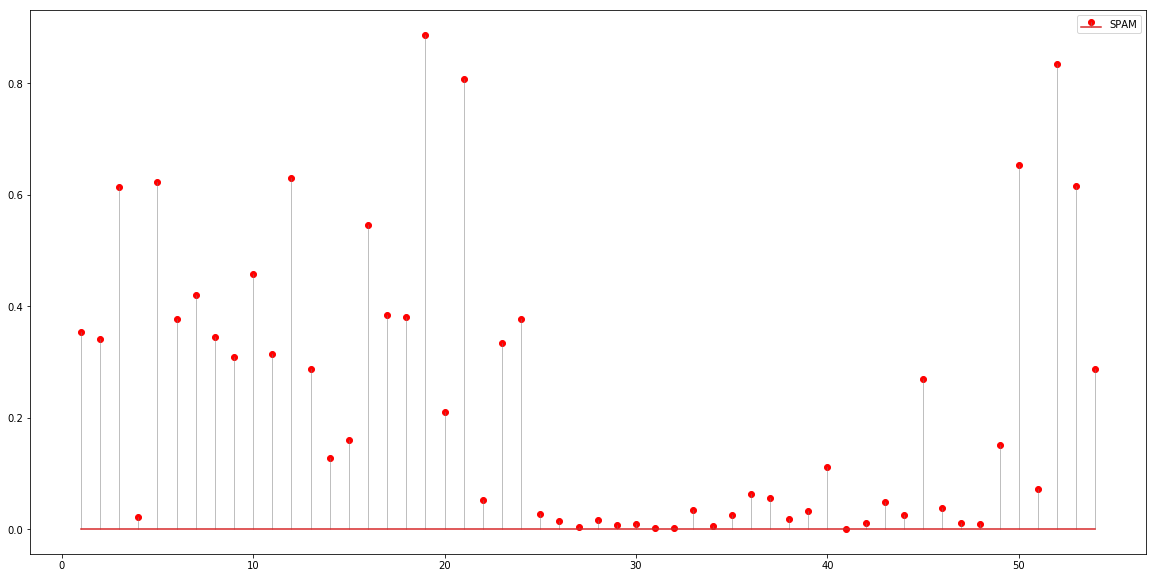

In [53]:
plt.figure(figsize=(20, 10))
markerline, stemlines, baseline = plt.stem(indexes, bt_1, label="SPAM")
plt.setp(markerline, color='r')
plt.setp(stemlines, color='grey', linestyle='-', linewidth=.5)
plt.legend()
plt.show()

dim 16 corresponds to the word "free". bernoulli's theta for spam case is high compared to that of not spam case meaning the existence of the word free in an email positively contributes to the probability of it being a spam compared to not spam.

same with dim 52 which corresponds to "!".

this does make sense because promotional spam offer "free" services and products and "!" can be used as a way to make the offers sounds exciting.

### Problem 2 - c

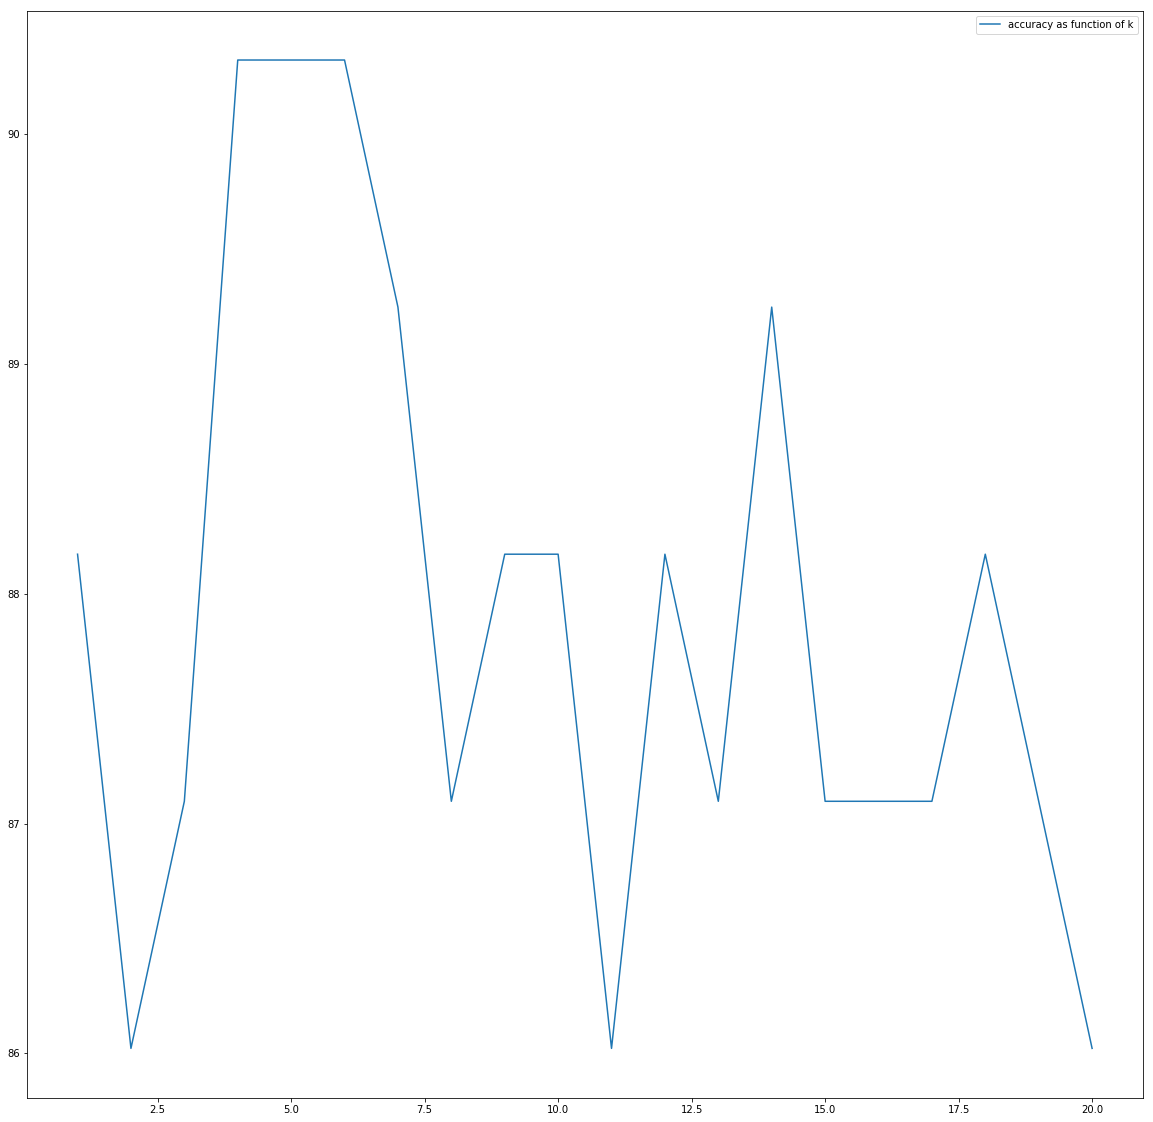

In [54]:
knnc = KNNC()
knnc.fit(X_train, y_train)
RNNs = knnc.ranked_NNs(X_test)
preds= []
accuracies = []
for k in range(1,21):
    pred = knnc.forward_pass(k, RNNs).flatten()
    preds.append(pred)
    
preds= np.array(preds)


for k in range(1,21):
    count = 0
    for i, p in enumerate(preds[k-1, :]):
        if y_test.flatten()[i] == p:
            count += 1
    accur = count/y_test.size*100
    accuracies.append(accur)

plt.figure(figsize=(20, 20))
plt.plot(range(1,21), accuracies, label= "accuracy as function of k")
plt.legend()
plt.show()

### Problem 2 - d

In [55]:
lrcGA = LRC()
itersGA, LsGA = lrcGA.fit_train(X_train, y_train, n_iterations = 10000, LR_fun = "GA")

The previous step is super long :(

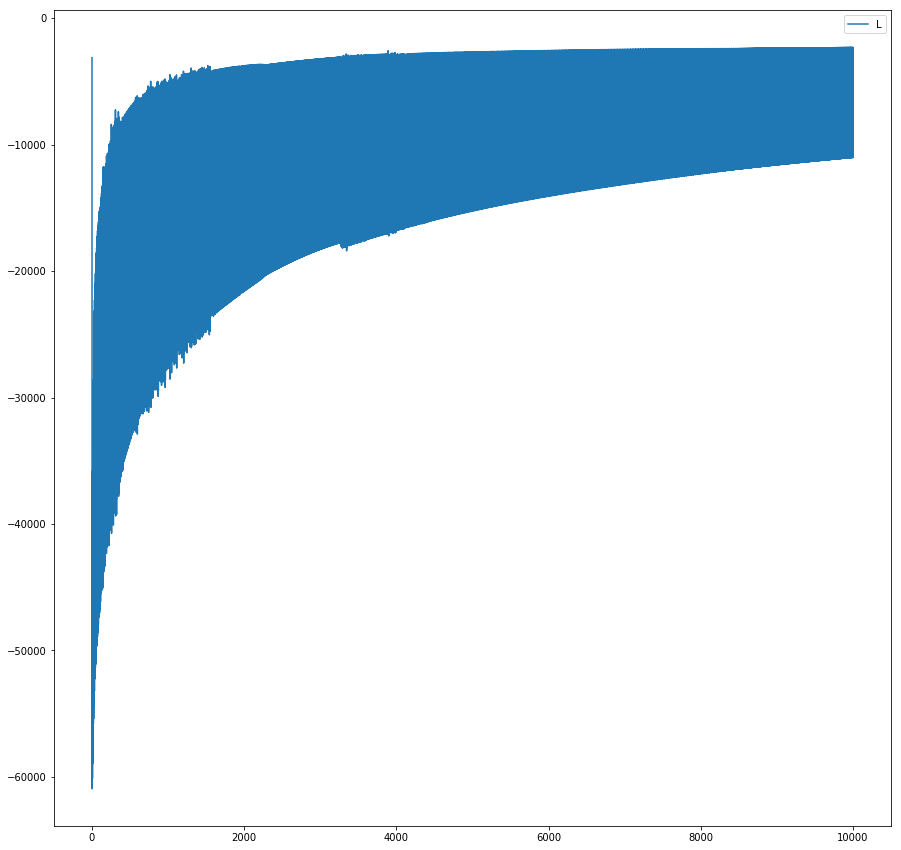

In [56]:
plt.figure(figsize=(15, 15))
plt.plot(itersGA, LsGA, label='L')
plt.legend()
plt.show()

### Problem 2 - e

In [ ]:
lrcN = LRC()
itersN, LsN = lrcN.fit_train(X_train, y_train, n_iterations = 100, LR_fun = "N")

In [ ]:
plt.figure(figsize=(12, 13))
plt.plot(itersN, LsN, label='L')
plt.legend()
plt.show()

In [ ]:
print("Accuracy: ", np.extract(y_test==lrcN.forward_pass(X_test), y_test).size/y_test.size*100)